In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import pandas as pd
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import numpy as np
from sklearn.cluster import KMeans
from CONSTANTS import ALSO_USE_CLINICAL_DATA
from sklearn.model_selection import train_test_split

In [41]:
USE_ONLY_OS = False
USE_ONLY_EFS = False
SEED = 42
TEST_SIZE = .2
np.random.seed(SEED)

# HEADERS = ["Patient_ID","EPAS1","ERC2","PRC1","CSGALNACT1","CCND1","OS_event","OS_time","EFS_event","EFS_time", "ISS Staging"]
dataset = pd.read_csv("./final_columns.csv").dropna()

In [42]:
FEATURES = parameters = [
    "EPAS1",
    "ERC2",
    "PRC1",
    "CSGALNACT1",
    "CCND1"
    ]

if ALSO_USE_CLINICAL_DATA:
    parameters += ["Age", "Albumin", "B2m", "Hemoglobin"]
    FEATURES = parameters + ["Cyto"]


OS_TIME_COL = "OS_time"
EFS_TIME_COL = "EFS_time"
OS_EVENT_COL = "OS_event"
EFS_EVENT_COL = "EFS_event"
times = [OS_TIME_COL, EFS_TIME_COL]

stratify_key = dataset[OS_EVENT_COL].astype(str) + "_" + dataset[EFS_EVENT_COL].astype(str)
stratify_key = dataset["ISS Staging"]
train_idx, test_idx = train_test_split(
    dataset.index,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=stratify_key
)

X_train = dataset.loc[train_idx].copy()
X_test  = dataset.loc[test_idx].copy()

In [43]:

best = {}
os_event = X_train[OS_EVENT_COL].to_numpy()
efs_event = X_train[EFS_EVENT_COL].to_numpy()

for param in parameters:
    best[param] = {}
    min_p_os = np.inf
    min_p_pfs = np.inf
    x = X_train[param].to_numpy()
    uniq = np.unique(x)    #sorted list of unique non-missing values
    if uniq.size<2:
        continue
    for u in uniq:
        left = x<=u
        right = x>u
        n_left, n_right = int(left.sum()), int(right.sum())
        if n_left == 0 or n_right == 0:
            continue

        for tm in times:
            if tm == OS_TIME_COL:  e = os_event
            if tm == EFS_TIME_COL:  e = efs_event
            
            t = X_train[tm].to_numpy()
            res = logrank_test(
                t[left], t[right],
                event_observed_A=e[left],
                event_observed_B=e[right]
            )
            stat = float(res.test_statistic)
            pval = float(res.p_value)
            if tm == OS_TIME_COL:
                if pval<=min_p_os:
                    min_p_os = pval
                    best[param]["OS"] = u
                    best[param]["OS_p"] = pval
            elif tm == EFS_TIME_COL:
                if pval<=min_p_pfs:
                    min_p_pfs = pval
                    best[param]["EFS"] = u
                    best[param]["EFS_p"] = pval

In [44]:
best["Cyto"] = {}
best["Cyto"]["EFS_p"] = 0
best["Cyto"]["OS_p"] = 0
best["Cyto"]["OS"] = 0.5
best["Cyto"]["EFS"] = 0.5

In [45]:
THRESHOLD = {}

if USE_ONLY_OS:
    print("USING ONLY OS")
    for param in best.keys():
        THRESHOLD[param] = best[param]["OS"]
elif USE_ONLY_EFS:
    print("USING ONLY EFS")
    for param in best.keys():
        THRESHOLD[param] = best[param]["EFS"]
else:
    print("parameter\tValue\tp-value")
    print(best)
    for param in best.keys():
        EFS_IS_BETTER = best[param]["EFS_p"] < best[param]["OS_p"]
        print()
        print(param)
        print("EFS:\t\t", best[param]["EFS"], "\t", best[param]["EFS_p"], "\t<=====BEST====="*EFS_IS_BETTER)
        print("OS:\t\t", best[param]["OS"], "\t", best[param]["OS_p"], "\t<=====BEST====="*(not EFS_IS_BETTER))
        THRESHOLD[param] = best[param]["EFS"] if best[param]["EFS_p"] < best[param]["OS_p"] else best[param]["OS"]
        THRESHOLD[param] = float(THRESHOLD[param])
print(THRESHOLD)

parameter	Value	p-value
{'EPAS1': {'OS': np.float64(6.8719), 'OS_p': 1.1107754804490302e-05, 'EFS': np.float64(8.6093), 'EFS_p': 9.736187580069846e-08}, 'ERC2': {'OS': np.float64(2.113), 'OS_p': 0.0029325394687141604, 'EFS': np.float64(2.113), 'EFS_p': 7.766366964764944e-05}, 'PRC1': {'OS': np.float64(10.4947), 'OS_p': 1.1093661443820453e-05, 'EFS': np.float64(4.4355), 'EFS_p': 5.950414744707368e-15}, 'CSGALNACT1': {'OS': np.float64(10.545), 'OS_p': 1.0215215746847323e-06, 'EFS': np.float64(8.7195), 'EFS_p': 5.6369813400351e-05}, 'CCND1': {'OS': np.float64(3.2879), 'OS_p': 6.87960106487547e-06, 'EFS': np.float64(9.7804), 'EFS_p': 0.0002176463934884197}, 'Age': {'OS': np.float64(75.93960192175703), 'OS_p': 4.946107886769867e-12, 'EFS': np.float64(66.92107069320522), 'EFS_p': 0.030075398775183032}, 'Albumin': {'OS': np.float64(4.0), 'OS_p': 4.944507176531549e-07, 'EFS': np.float64(3.7), 'EFS_p': 0.004511026089293938}, 'B2m': {'OS': np.float64(16.2), 'OS_p': 3.812694999310329e-19, 'EFS': 

In [46]:
subset = X_train[[OS_TIME_COL, OS_EVENT_COL] + [EFS_TIME_COL, EFS_EVENT_COL] + FEATURES + ["ISS Staging", "Patient_ID"]]
n_before = len(subset)
subset_clean = subset.dropna()
n_after = len(subset_clean)
print(f"Dropped {n_before - n_after} rows with NaNs.")

X_train = subset_clean

Dropped 0 rows with NaNs.


In [47]:
cph = CoxPHFitter()
cph.fit(X_train[[OS_TIME_COL, OS_EVENT_COL] + FEATURES ], duration_col=OS_TIME_COL, event_col=OS_EVENT_COL)
hr_os = cph.hazard_ratios_.rename("OS")

cph.fit(X_train[[EFS_TIME_COL, EFS_EVENT_COL] + FEATURES ], duration_col=EFS_TIME_COL, event_col=EFS_EVENT_COL)
hr_efs = cph.hazard_ratios_.rename("EFS")

hr_df = pd.concat([hr_os, hr_efs], axis=1)

if USE_ONLY_OS:
    print("Using only OS")
    hr_df["Higher_HR"] = hr_df["OS"]
elif USE_ONLY_EFS:
    print("Using only PFS")
    hr_df["Higher_HR"] = hr_df["EFS"]
else:
    print("Using both OS & PFS")
    hr_df["Higher_HR"] = hr_df.max(axis=1)

NEW_MIN = 1
NEW_MAX = 4

hr_df["normalized"] = 1 + (hr_df["Higher_HR"] - hr_df["Higher_HR"].min())/(hr_df["Higher_HR"].max() - hr_df["Higher_HR"].min()) * (NEW_MAX - NEW_MIN)

print("=== Hazard Ratios from OS vs EFS ===")
print(hr_df)

weights = hr_df["normalized"].to_dict()
weights


Using both OS & PFS
=== Hazard Ratios from OS vs EFS ===
                  OS       EFS  Higher_HR  normalized
covariate                                            
EPAS1       0.851962  0.769385   0.851962    1.000000
ERC2        0.892311  0.929895   0.929895    1.183097
PRC1        1.175137  1.051923   1.175137    1.759267
CSGALNACT1  0.799416  0.869960   0.869960    1.042285
CCND1       0.965478  0.923348   0.965478    1.266696
Age         1.022464  1.003486   1.022464    1.400579
Albumin     0.682696  0.967939   0.967939    1.272477
B2m         1.061717  1.023133   1.061717    1.492800
Hemoglobin  1.048871  0.908081   1.048871    1.462619
Cyto        2.128884  1.688857   2.128884    4.000000


{'EPAS1': 1.0,
 'ERC2': 1.1830972701395321,
 'PRC1': 1.7592672791257786,
 'CSGALNACT1': 1.0422854732831055,
 'CCND1': 1.266695795384976,
 'Age': 1.4005786683959542,
 'Albumin': 1.2724766765945155,
 'B2m': 1.4927996572573217,
 'Hemoglobin': 1.4626185533472529,
 'Cyto': 4.0}

In [48]:

"""
    Among them, EPAS1,
    ERC2, CSGALNACT1, and CCND (hazard ratio <1) were
    protective genes, while PRC1 was a harmful gene (hazard ratio
    >1). [Page 4]
"""
high_risk_side = {
    "EPAS1": "<",
    "ERC2": "<",
    "PRC1": ">",
    "CSGALNACT1": "<",
    "CCND1": "<",
    "Age": ">",
    "Albumin": "<",
    "B2m": ">",
    "Hemoglobin": "<",
    "Cyto": ">"
}

scores_train = pd.Series(0.0, index=X_train.index, name="risk_score")

for p in FEATURES:
    thr  = THRESHOLD[p]
    w    = weights[p]
    side = high_risk_side[p]

    col_tr = X_train[p]

    if side == '>':
        mask_tr = col_tr > thr
    else:
        mask_tr = col_tr < thr

    scores_train += w * mask_tr.astype(float)


In [49]:
# %%
# === GMM clustering (3 components) on TRAIN risk scores ===
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd

# you already have: scores_train (continuous risk score, e.g., from weighted features or Cox)
# ensure it's a 1-D column vector
rep_train = scores_train.values.reshape(-1, 1)

# Fit GMM with 3 components
gmm = GaussianMixture(n_components=3, random_state=SEED, n_init=10, covariance_type="full")
labels_train = gmm.fit_predict(rep_train)

# Order clusters by ascending median risk (so GENEI-1 = lowest risk)
def map_by_median(labels, scores, prefix="GENEI-"):
    labels = pd.Series(labels, index=scores.index)
    uniq = np.unique(labels)
    med = {k: float(scores[labels == k].median()) for k in uniq}
    order = sorted(uniq, key=lambda k: (med[k], k))
    rank_map = {k: f"{prefix}-{i+1}" for i, k in enumerate(order)}
    return labels.map(rank_map), med

risk_train, med = map_by_median(labels_train, scores_train, prefix="GENEI-")

# Final TRAIN frame and labels
train_labeled = X_train.copy()
train_labeled["risk_score"] = scores_train
train_labeled["risk_group"] = risk_train
y_train = train_labeled["risk_group"].copy()

print("GMM cluster sizes:")
print(y_train.value_counts().sort_index())

# Keep the GMM model for TEST scoring
gmm_artifacts = {"model": gmm, "med": med}


GMM cluster sizes:
risk_group
GENEI--1     75
GENEI--2    189
GENEI--3    182
Name: count, dtype: int64


In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# Assumes you already have: X_train, y_train, SEED

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 3, 4, 5, 6, 8, 10],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": [0.0, 1e-4, 5e-4, 1e-3],  # cost-complexity pruning
    "class_weight": [None, "balanced"],
}

scoring = {
    "bal_acc": "balanced_accuracy",
    "accuracy": "accuracy",
    "f1_weighted": "f1_weighted",
    "f1_macro": "f1_macro",
}

dt_base = DecisionTreeClassifier(random_state=SEED)

grid = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    scoring=scoring,
    refit="bal_acc",            # choose the best by balanced accuracy
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train[FEATURES], y_train)

print("Best params:", grid.best_params_)
print("Best CV balanced accuracy:", grid.best_score_)
best_dt = grid.best_estimator_



Fitting 5 folds for each of 8064 candidates, totalling 40320 fits
Best params: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV balanced accuracy: 0.985577682946104


In [51]:
best_dt = grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)

print(best_dt)
print("\nTree depth:", best_dt.get_depth())
print("Number of leaves:", best_dt.get_n_leaves())
print("Training accuracy:", best_dt.score(X_train[FEATURES], y_train))


{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.985577682946104
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=42)

Tree depth: 4
Number of leaves: 8
Training accuracy: 0.9910313901345291


In [52]:

# from sklearn.tree import DecisionTreeClassifier
# BEST_PARAMS = {
#     "ccp_alpha": 0.0,
#     "class_weight": None,
#     "criterion": "gini",
#     "max_depth": None,
#     "max_features": None,
#     "min_samples_leaf": 2,
#     "min_samples_split": 5,
# }

# dt = DecisionTreeClassifier(random_state=SEED, **BEST_PARAMS)
# dt.fit(X_train[FEATURES], y_train)

# print(dt)
# print("Tree depth:", dt.get_depth())
# print("Number of leaves:", dt.get_n_leaves())
# print("Training accuracy:", dt.score(X_train[FEATURES], y_train))

In [53]:
y_pred = best_dt.predict(X_test[FEATURES])

In [54]:
# %%
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.utils import concordance_index

def ordered_numeric_from_labels(labels):
    """
    Converts categorical labels like 'GENEI-1', 'GENEI-2', 'I', 'II', 'III' 
    into numeric order for C-index (higher number = higher risk).
    """
    labels = pd.Series(labels).astype(str).str.strip().replace({"nan": "Unknown"})
    # Generic pattern: extract trailing digits if exist, else rank categories alphabetically
    numeric = labels.str.extract(r"(\\d+)$")[0]
    if numeric.notna().any():
        return numeric.astype(float).to_numpy()
    else:
        uniq = sorted(labels.unique())
        mapper = {u: i+1 for i, u in enumerate(uniq)}
        return labels.map(mapper).to_numpy()

def km_compare_and_cindex(time_arr, event_arr, groups, title_prefix, enforce_order=None):
    """
    Draw KM curves by categorical group labels, compute logrank p and C-index.
    """
    groups = pd.Series(groups, name="group").astype(str).replace("nan", "Unknown")
    mask = groups.notna() & groups.ne("")
    groups = groups[mask]
    time = np.array(time_arr)[mask]
    event = np.array(event_arr)[mask]

    # If enforce_order provided, use it for consistent ordering
    if enforce_order is not None:
        order = [g for g in enforce_order if g in groups.unique()]
    else:
        # order by median survival (shorter median = higher risk)
        kmf_tmp = KaplanMeierFitter()
        med = {}
        for g in groups.unique():
            kmf_tmp.fit(time[groups == g], event_observed=event[groups == g])
            med[g] = kmf_tmp.median_survival_time_ or np.inf
        order = [g for g, _ in sorted(med.items(), key=lambda kv: (kv[1], str(kv[0])))]

    kmf = KaplanMeierFitter()
    plt.figure(figsize=(7,5))
    for g in order:
        mask_g = (groups == g).to_numpy()
        kmf.fit(time[mask_g], event_observed=event[mask_g], label=str(g))
        kmf.plot(ci_show=False)
    plt.title(f"{title_prefix} — Kaplan–Meier")
    plt.xlabel("Time")
    plt.ylabel("Survival probability")
    plt.grid(alpha=0.3)
    plt.show()

    # Logrank test
    lr = multivariate_logrank_test(event_durations=time, event_observed=event, groups=groups)
    pval = lr.p_value

    # C-index (higher = better discrimination)
    risk_numeric = ordered_numeric_from_labels(groups)
    cval = concordance_index(time, -risk_numeric, event)

    print(f"{title_prefix}: logrank p = {pval:.3e},  C-index = {cval:.3f}")


In [55]:
# %%
# Prepare series for test survival
OS_time_te  = X_test[OS_TIME_COL].to_numpy()
OS_event_te = X_test[OS_EVENT_COL].to_numpy()
EFS_time_te  = X_test[EFS_TIME_COL].to_numpy()
EFS_event_te = X_test[EFS_EVENT_COL].to_numpy()

# Predicted risk groups
groups_dt = pd.Series(y_pred, index=X_test.index, name="DT_predicted_group")

# ISS Staging (ensure clean categorical)
iss_groups = X_test["ISS Staging"].astype(str).replace({"nan": "Unknown"}).fillna("Unknown")

# Check distributions
print("Decision Tree groups (test):")
print(groups_dt.value_counts())
print("\nISS Staging groups (test):")
print(iss_groups.value_counts())


Decision Tree groups (test):
DT_predicted_group
GENEI--2    46
GENEI--3    44
GENEI--1    22
Name: count, dtype: int64

ISS Staging groups (test):
ISS Staging
I      59
II     30
III    23
Name: count, dtype: int64


=== Decision Tree Predicted Risk Groups ===


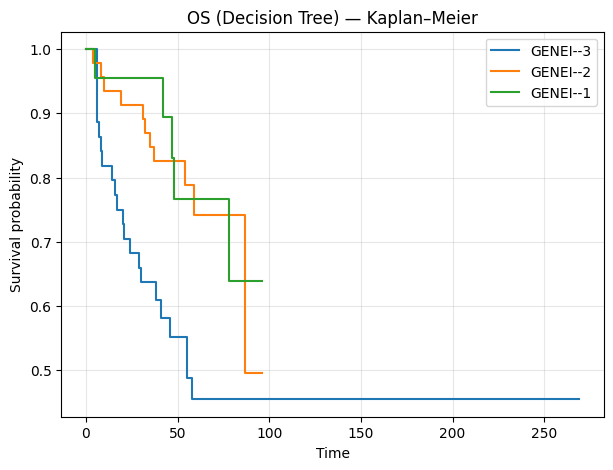

OS (Decision Tree): logrank p = 1.251e-02,  C-index = 0.647


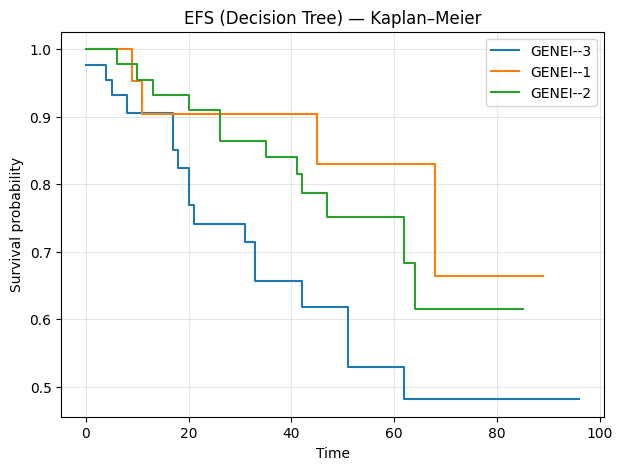

EFS (Decision Tree): logrank p = 9.533e-02,  C-index = 0.621

=== ISS Staging ===


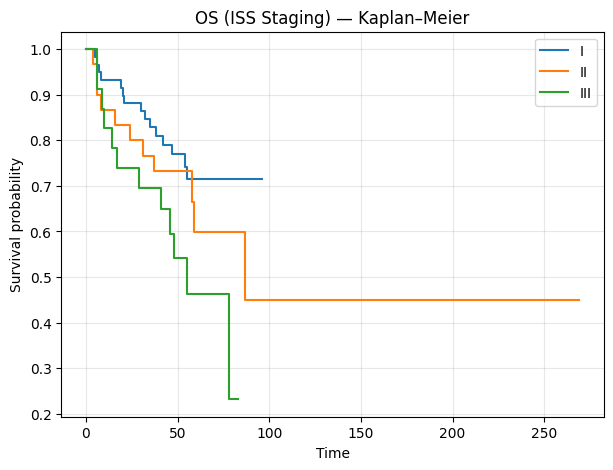

OS (ISS Staging): logrank p = 4.894e-02,  C-index = 0.587


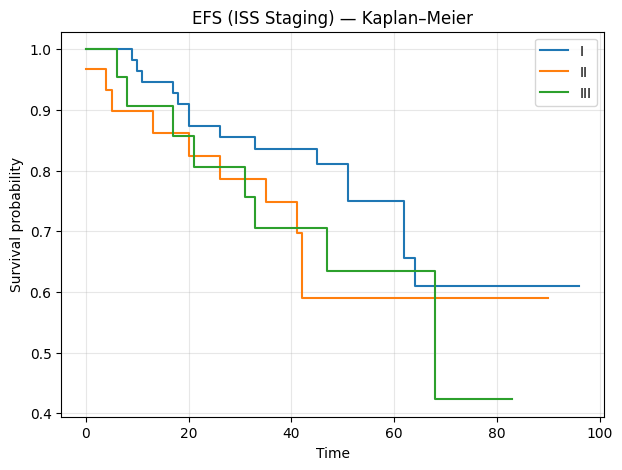

EFS (ISS Staging): logrank p = 4.147e-01,  C-index = 0.571


In [56]:
# %%
# === Decision Tree vs OS / EFS ===
print("=== Decision Tree Predicted Risk Groups ===")
km_compare_and_cindex(OS_time_te,  OS_event_te,  groups_dt,  "OS (Decision Tree)")
km_compare_and_cindex(EFS_time_te, EFS_event_te, groups_dt,  "EFS (Decision Tree)")

# === ISS Staging vs OS / EFS ===
print("\n=== ISS Staging ===")
# use natural clinical order for ISS if present
iss_order = ["I", "II", "III", "Unknown"]
km_compare_and_cindex(OS_time_te,  OS_event_te,  iss_groups,  "OS (ISS Staging)",  enforce_order=iss_order)
km_compare_and_cindex(EFS_time_te, EFS_event_te, iss_groups,  "EFS (ISS Staging)", enforce_order=iss_order)


In [57]:
# %%
# === Compare Decision Tree vs ISS Staging on survival metrics ===

def get_km_stats(time_arr, event_arr, groups, title, enforce_order=None):
    """Utility that returns a dict of stats instead of printing."""
    from lifelines.statistics import multivariate_logrank_test
    from lifelines.utils import concordance_index
    import numpy as np
    import pandas as pd

    groups = pd.Series(groups, name="group").astype(str).replace("nan", "Unknown")
    mask = groups.notna() & groups.ne("")
    groups = groups[mask]
    time = np.array(time_arr)[mask]
    event = np.array(event_arr)[mask]

    # Logrank
    lr = multivariate_logrank_test(event_durations=time, event_observed=event, groups=groups)
    pval = lr.p_value

    # C-index
    risk_num = ordered_numeric_from_labels(groups)
    cval = concordance_index(time, -risk_num, event)

    return {
        "Model": title,
        "N groups": len(groups.unique()),
        "Logrank p": pval,
        "C-index": cval,
    }

# compute stats
res_dt_os  = get_km_stats(OS_time_te,  OS_event_te,  groups_dt,  "Decision Tree (OS)")
res_dt_efs = get_km_stats(EFS_time_te, EFS_event_te, groups_dt,  "Decision Tree (EFS)")
res_iss_os  = get_km_stats(OS_time_te,  OS_event_te,  iss_groups,  "ISS Staging (OS)")
res_iss_efs = get_km_stats(EFS_time_te, EFS_event_te, iss_groups,  "ISS Staging (EFS)")

# Combine into a DataFrame
summary_df = pd.DataFrame([res_dt_os, res_dt_efs, res_iss_os, res_iss_efs])

# Tidy up and pretty print
summary_df["Logrank p (sci)"] = summary_df["Logrank p"].map(lambda x: f"{x:.3e}")
summary_df["C-index"] = summary_df["C-index"].map(lambda x: f"{x:.3f}")

summary_df = summary_df[["Model", "N groups", "Logrank p (sci)", "C-index"]]
print("=== Survival comparison: Decision Tree vs ISS Staging ===")
display(summary_df.style.set_table_styles(
    [{"selector": "th", "props": [("background-color", "#444"), ("color", "white"), ("text-align", "center")]}]
).background_gradient(subset=["C-index"], cmap="YlGn"))


=== Survival comparison: Decision Tree vs ISS Staging ===


,Model,N groups,Logrank p (sci),C-index
0,Decision Tree (OS),3,1.251e-02,0.647
1,Decision Tree (EFS),3,9.533e-02,0.621
2,ISS Staging (OS),3,4.894e-02,0.587
3,ISS Staging (EFS),3,4.147e-01,0.571
